data from [A longitudinal single-cell atlas of treatment response in pediatric AML](https://www.sciencedirect.com/science/article/pii/S1535610823003641?via%3Dihub)

In [ ]:
import numpy as np
import os
from CoPhaser import utils
from CoPhaser.trainer import Trainer
from CoPhaser.loss import Loss
from CoPhaser import plotting
from CoPhaser.model import CoPhaser
from CoPhaser import gene_sets
from importlib import resources


import matplotlib.pyplot as plt
import seaborn as sns

import anndata
import scanpy as sc

import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DATA = "../../../data/"

In [4]:
adata = anndata.read_h5ad(
    DATA + "pediatric_cancer/GSE235063/all_patients_processed.h5ad"
)
adata.obs_names_make_unique()

/home/maxine/miniconda3/envs/CoPhaser_Env/lib/python3.13/site-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
adata.layers["total"] = adata.X.copy()

In [6]:
rhythmic_genes = gene_sets.SMALL_CELL_CYCLE_GENE_SET
rhythmic_genes = [g.upper() for g in rhythmic_genes]

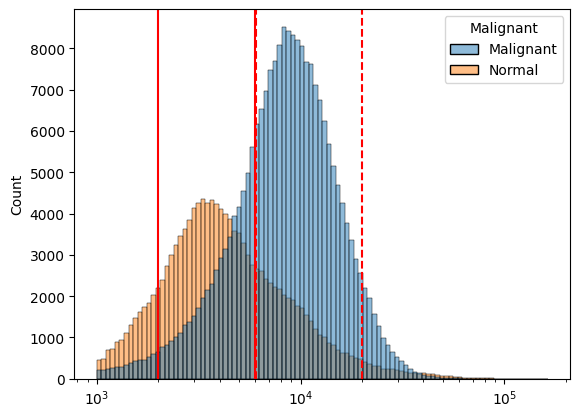

In [7]:
sns.histplot(
    x=adata.X.sum(axis=1).A1, bins=100, log_scale=True, hue=adata.obs["Malignant"]
)
min_normal = 2000
max_normal = 6000
min_malignant = 6050
max_malignant = 20000
plt.axvline(min_normal, color="red")
plt.axvline(max_normal, color="red")
plt.axvline(min_malignant, color="red", linestyle="--")
plt.axvline(max_malignant, color="red", linestyle="--")

In [8]:
i_to_keep = (
    (adata.obs["Malignant"] == "Normal")
    & (adata.X.sum(axis=1).A1 >= min_normal)
    & (adata.X.sum(axis=1).A1 <= max_normal)
) | (
    (adata.obs["Malignant"] == "Malignant")
    & (adata.X.sum(axis=1).A1 >= min_malignant)
    & (adata.X.sum(axis=1).A1 <= max_malignant)
)
adata = adata[i_to_keep, :].copy()
adata.obs["Malignant"].value_counts()

Malignant
Malignant    149842
Normal        77386
Name: count, dtype: int64

<Axes: xlabel='n_cell_cycle_counts', ylabel='Count'>

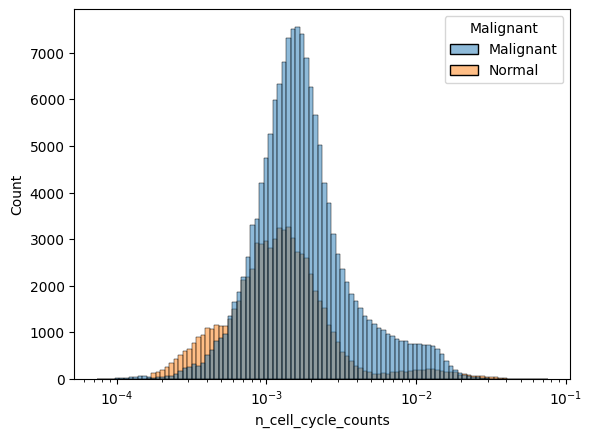

In [9]:
adata.obs["n_cell_cycle_counts"] = (
    adata[:, rhythmic_genes].X.sum(axis=1).A1 / adata.X.sum(axis=1).A1
)
sns.histplot(
    x=adata.obs["n_cell_cycle_counts"],
    bins=100,
    log_scale=True,
    hue=adata.obs["Malignant"],
)

In [10]:
adata.obs["Malignant"].value_counts()

Malignant
Malignant    149842
Normal        77386
Name: count, dtype: int64

In [11]:
# take 20% of the normal cells for training
i = (
    adata[adata.obs["Malignant"] == "Malignant"]
    .obs.sample(frac=0.8, random_state=1)
    .index
)
i = i.union(
    adata[adata.obs["Malignant"] == "Normal"].obs.sample(frac=0.8, random_state=1).index
)
adata = adata[i, :].copy()
adata.obs["Malignant"].value_counts()

Malignant
Malignant    119874
Normal        61909
Name: count, dtype: int64

In [12]:
adata.layers["total"] = adata.X.copy()

In [13]:
var_g = utils.get_variable_genes(adata, n_variable_genes=2000, layer="total")

In [14]:
adata.obs["Malignant"].value_counts()

Malignant
Malignant    119874
Normal        61909
Name: count, dtype: int64

/home/maxine/miniconda3/envs/CoPhaser_Env/lib/python3.13/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/maxine/miniconda3/envs/CoPhaser_Env/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


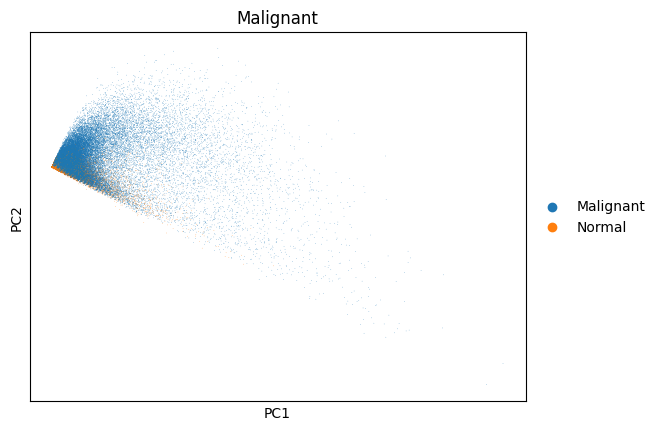

In [15]:
# PCA
import scipy

adata_PCA = adata.copy()
X = adata_PCA.layers["total"]  # CSR matrix
row_sums = X.sum(axis=1).A1 * 1e4  # shape (n_cells,)

# In CSR format, row-wise division works with broadcasting if you reshape
X_norm = scipy.sparse.csr_matrix(X.multiply(1.0 / row_sums[:, None]))

adata_PCA.layers["total"] = np.log1p(X_norm * 1e4)
adata_PCA = adata_PCA[:, rhythmic_genes]
# get the z normalized data
sc.pp.scale(adata_PCA, layer="total", max_value=10)
sc.tl.pca(adata_PCA, n_comps=10)
sc.pl.pca(adata_PCA, color="Malignant")
pca_theta = np.arctan2(adata_PCA.obsm["X_pca"][:, 1], adata_PCA.obsm["X_pca"][:, 0])

In [16]:
adata.obs["pca_theta"] = pca_theta

In [17]:
SMALL_CYCLING_GENE_SET = [
    gene.upper()
    for gene in gene_sets.SMALL_CELL_CYCLE_GENE_SET
    if gene.upper() in adata.var_names
]

In [18]:
adata = adata[adata.obs.sample(frac=0.5, random_state=1).index].copy()

In [20]:
model = CoPhaser(
    SMALL_CYCLING_GENE_SET,
    var_g,
)  # , categorical_covariate_dims=[27])
model.load_anndata(
    adata, layer_to_use="total"
)  # , batch_name="cancer_type")#,categorical_covariates=["group"])

In [ ]:
import torch

f_coeffs_path = (
    resources.files("CoPhaser") / "resources" / "fourier_coefficients_RPE.csv"
)
f_coeffs = pd.read_csv(f_coeffs_path, index_col=0)
f_coeffs.drop("A_0", axis=1, inplace=True)
f_coeffs = f_coeffs.loc[model.rhythmic_gene_names].copy()
old_weights = model.rhythmic_decoder.fourier_coefficients.weight.detach().clone()
old_weights[model.rhythmic_gene_indices, :] = torch.tensor(f_coeffs.values).float()
old_weights = torch.nn.Parameter(old_weights)
model.rhythmic_decoder.fourier_coefficients.weight = old_weights
model.rhythmic_decoder.freeze_weights_genes(model.rhythmic_gene_indices)

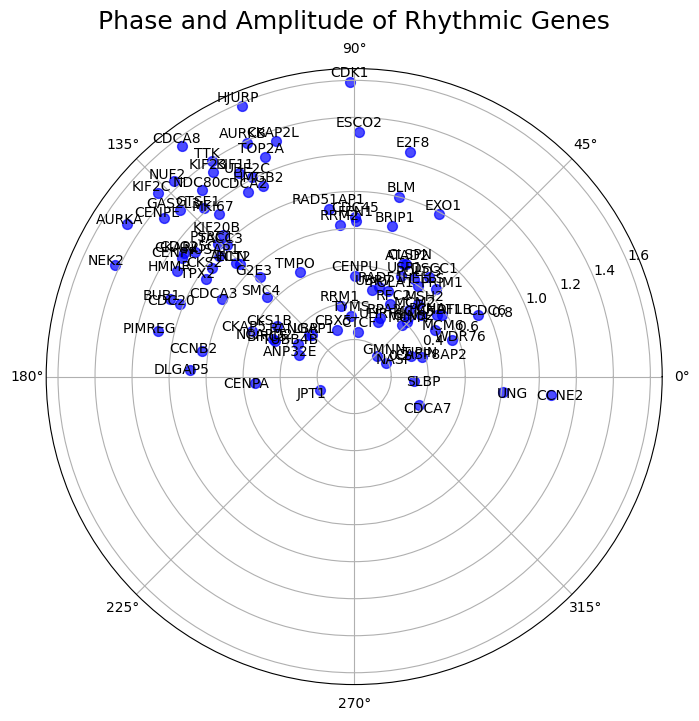

In [ ]:
model.plot_fourier_coefficients()

In [ ]:
trainer = Trainer(
    model,
    Loss.compute_loss,
    calculate_entropy_per_batch=False,
    L2_Z_decoder_loss_weight=0,
    entropy_weight_factor=100,
    closed_circle_weight=10,
    MI_weight=200,
    cycling_status_prior=0.1,
    beta_kl_cycling_status=20,
    unfreeze_epoch_layer=[(30, "rhythmic_decoder")],
    rhythmic_likelihood_weight=20,
    non_rhythmic_likelihood_weight=5,
)  # , entropy_weight_factor=5)
trainer.train_model(
    n_epochs=200,
    lr=1e-2,
    device="cuda",
    batch_size=8192,
)

Epoch 1/200, elbo_loss: 3277.6271, kl_div_f: 4.6777, kl_div_z: 24.7609, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.2263, entropy_loss: -322.6335, radial_variance: 2.4762, radius: 6.0481, L1_mu_z: 0.0000, MI_loss: 0.0000, total_loss: 2963.5179
Epoch 2/200, elbo_loss: 2743.5868, kl_div_f: 4.6224, kl_div_z: 35.1898, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.3676, entropy_loss: -336.7579, radial_variance: 3.3747, radius: 4.6350, L1_mu_z: 0.0000, MI_loss: 0.0011, total_loss: 2415.1098
Epoch 3/200, elbo_loss: 2591.7086, kl_div_f: 4.5654, kl_div_z: 29.4079, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.3928, entropy_loss: -339.2750, radial_variance: 2.0067, radius: 3.9089, L1_mu_z: 0.0000, MI_loss: 0.0063, total_loss: 2259.9126
Epoch 4/200, elbo_loss: 2509.5002, kl_div_f: 4.5024, kl_div_z: 27.1159, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.3985, en

KeyboardInterrupt: 

In [ ]:
f_coeffs = model.rhythmic_decoder.fourier_coefficients.weight[
    model.rhythmic_gene_indices
]
theta_genes = torch.atan2(f_coeffs[:, 1], f_coeffs[:, 0])

<Axes: ylabel='Count'>

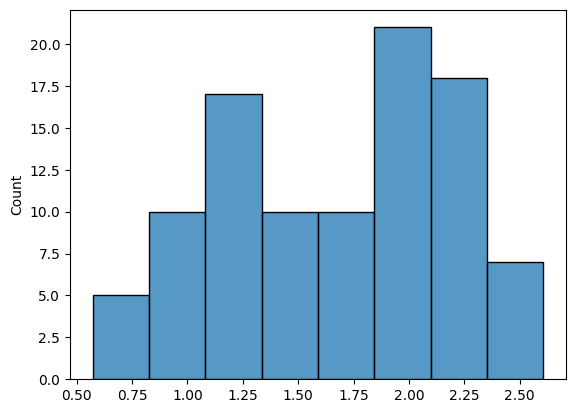

In [ ]:
sns.histplot(torch.arctan2(f_coeffs[:, 1], f_coeffs[:, 0]).detach().cpu().numpy())

<Axes: ylabel='Count'>

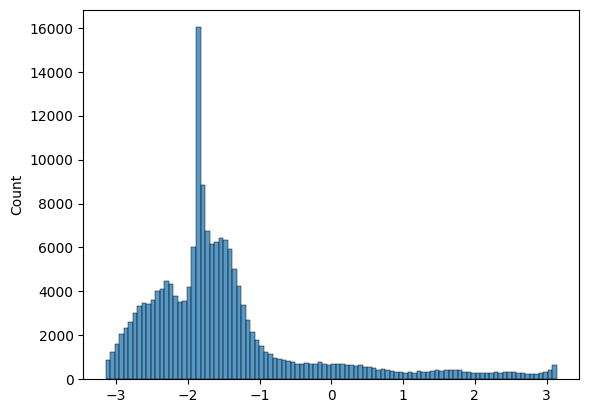

In [ ]:
# Get the infered theta values
model.to("cpu")
generative_outputs, space_outputs = model.get_outputs()
thetas = space_outputs["theta"].detach().numpy()
cycling_cells = space_outputs["b_z"].detach().numpy() > 0.5
sns.histplot(thetas, bins=100)

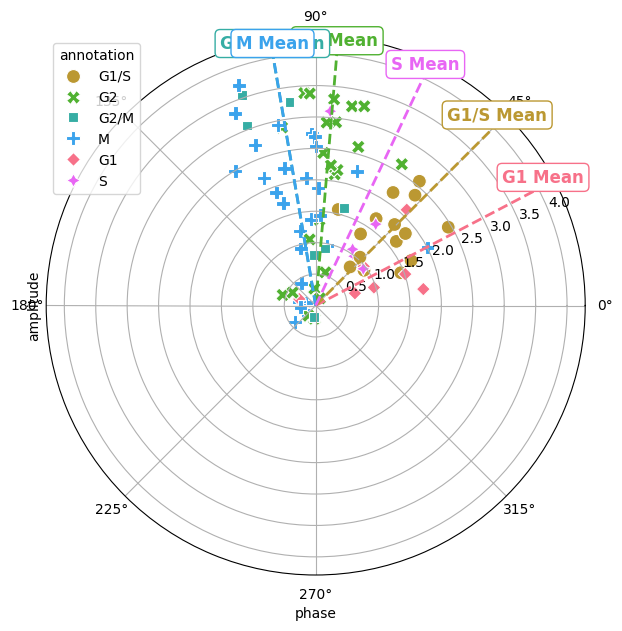

In [ ]:
thetas = model.infer_pseudotimes(adata, "total")

<Axes: >

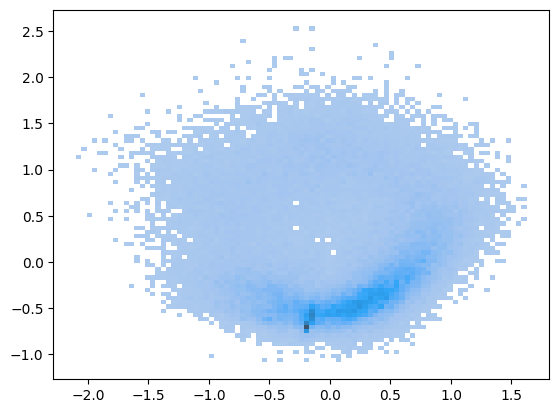

In [ ]:
cells_projected = space_outputs["x_projected"].detach().numpy()
sns.histplot(x=cells_projected[cycling_cells, 0], y=cells_projected[cycling_cells, 1])

<Axes: >

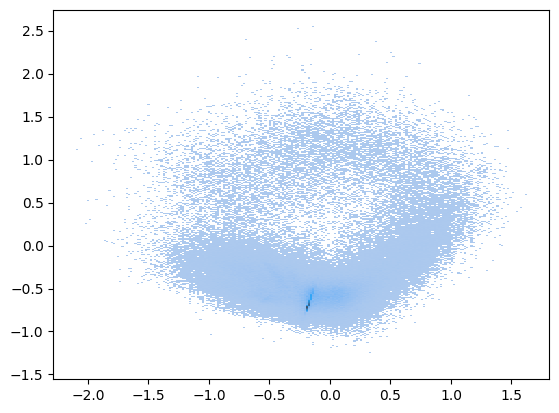

In [ ]:
sns.histplot(x=cells_projected[:, 0], y=cells_projected[:, 1])

<Axes: xlabel='None', ylabel='Count'>

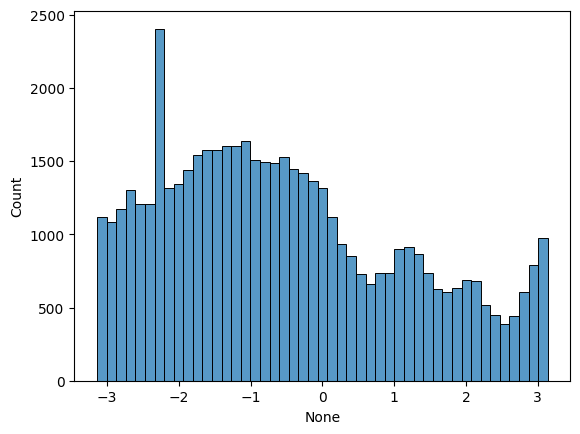

In [ ]:
sns.histplot(x=thetas[cycling_cells])

<Axes: xlabel='None', ylabel='Count'>

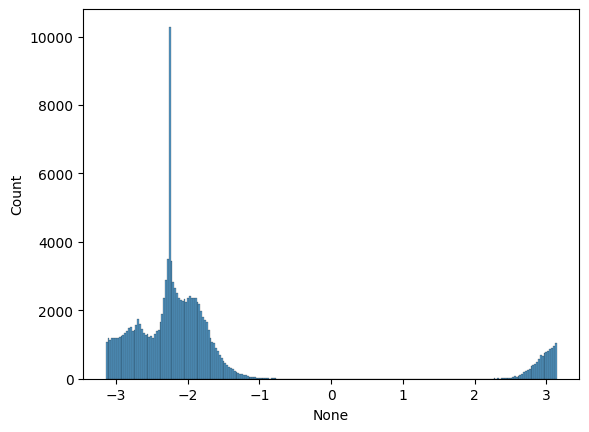

In [ ]:
sns.histplot(x=thetas[~cycling_cells])

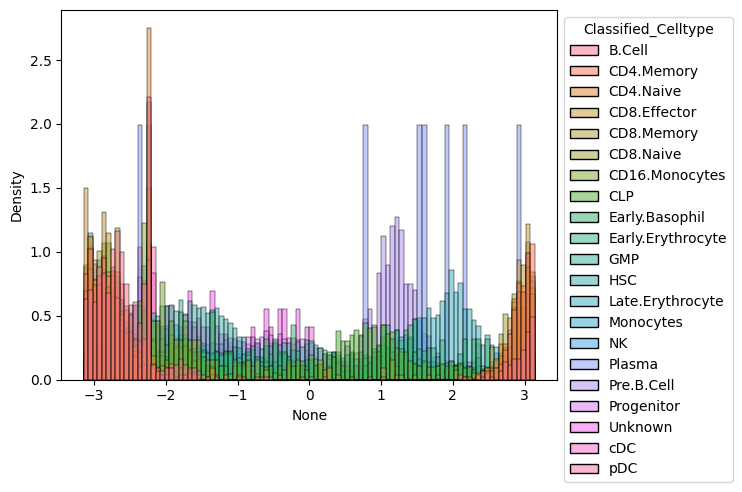

In [ ]:
ax = sns.histplot(
    x=thetas[cycling_cells],
    hue=adata.obs["Classified_Celltype"][cycling_cells],
    bins=100,
    stat="density",
    common_norm=False,
)
# move legend outside plot
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1))

<Axes: ylabel='Proportion'>

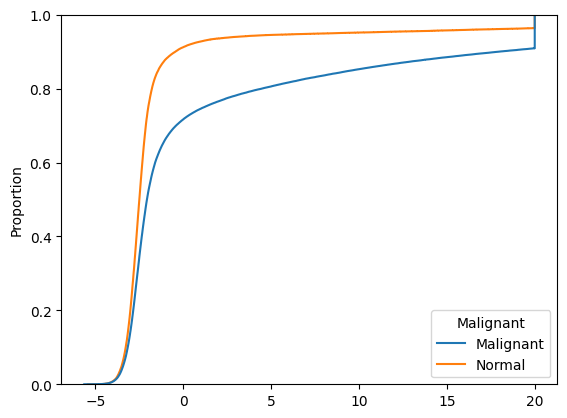

In [ ]:
sns.ecdfplot(
    x=space_outputs["cycling_logits"].detach().numpy(), hue=adata.obs["Malignant"]
)
# adata = adata_total[space_outputs["cycling_logits"].detach().numpy()>-20].copy()

(0.02, 1.0)

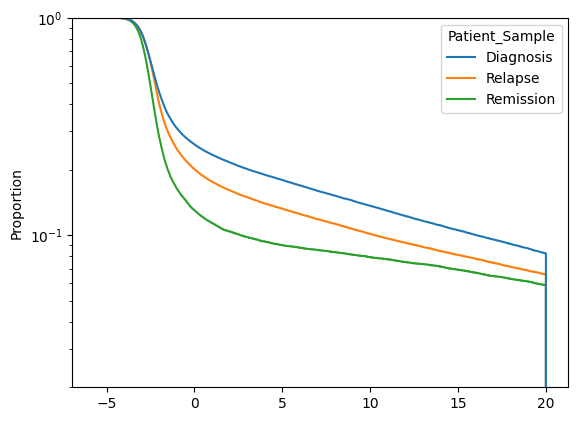

In [ ]:
sns.ecdfplot(
    x=space_outputs["cycling_logits"].detach().numpy(),
    hue=adata.obs["Patient_Sample"],
    complementary=True,
    log_scale=(False, True),
)
plt.ylim(2e-2)

In [ ]:
def add_theta(df, theta, theta_pca):
    df["inferred_theta"] = theta
    df["pca_theta"] = theta_pca
    return df


df_mean = pd.DataFrame(
    generative_outputs["px_rate"].detach().numpy(), columns=model.context_genes
)
df_mean = add_theta(df_mean, thetas, adata.obs["pca_theta"].values)
# df_rhythmic = pd.DataFrame(generative_outputs["rhythmic_term"].detach().numpy(), columns=model.rhythmic_gene_names)
df_rhythmic = pd.DataFrame(
    generative_outputs["F"].detach().numpy(), columns=model.context_genes
)
df_rhythmic = add_theta(df_rhythmic, thetas, adata.obs["pca_theta"].values)
df_z = pd.DataFrame(
    generative_outputs["Z"].detach().numpy(), columns=model.context_genes
)
df_z = add_theta(df_z, thetas, adata.obs["pca_theta"].values)

<Axes: xlabel='inferred_theta', ylabel='pca_theta'>

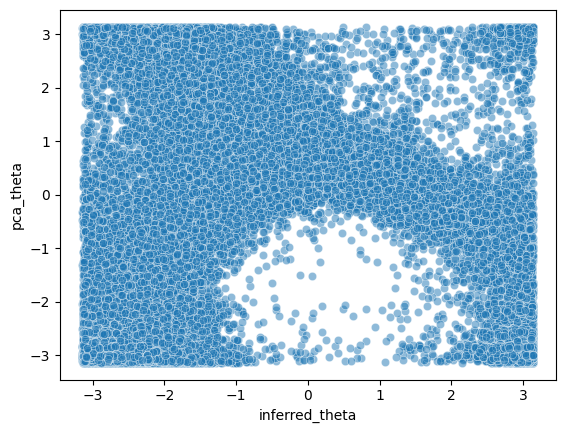

In [ ]:
sns.scatterplot(
    data=df_mean, x=df_mean["inferred_theta"], y=df_mean["pca_theta"], alpha=0.5
)

/home/maxine/Documents/paychere/cell_cycle_VAE_Fourrier_model/src/CoPhaser/plotting.py:492: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend(loc="upper left", bbox_to_anchor=(1, 1))


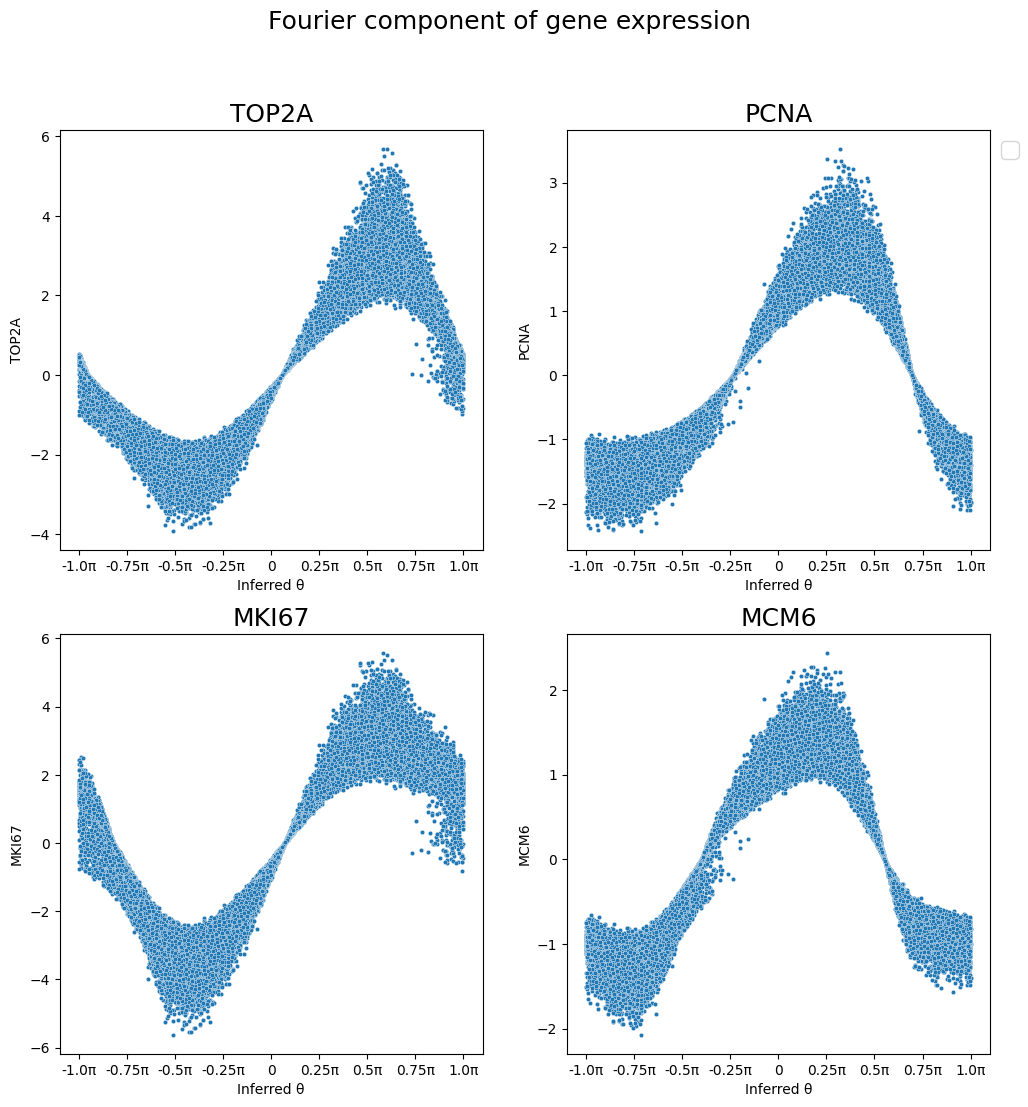

In [ ]:
plotting.plot_model_decoded_space(
    df_rhythmic.loc[cycling_cells],
    gene_to_upper=True,
    title="Fourier component of gene expression",
)

In [ ]:
def get_histones_peak_coherence(adata, thetas, layer_to_use):
    utils.add_histones_fraction(adata=adata, layer=layer_to_use)
    adata.obs["inferred_thetas"] = thetas
    var, range_ = utils.compute_smoothed_variance_and_range(
        adata,
        phase_layer="inferred_thetas",
        bin_size=0.3,
        counts_sum_field="histones_fraction",
        hue="sample_id",
    )
    return var, range_


get_histones_peak_coherence(adata, thetas, "total")

(1.5251075e-06, 9.173554)

In [ ]:
library_size = adata.layers["total"].sum(axis=1).A1

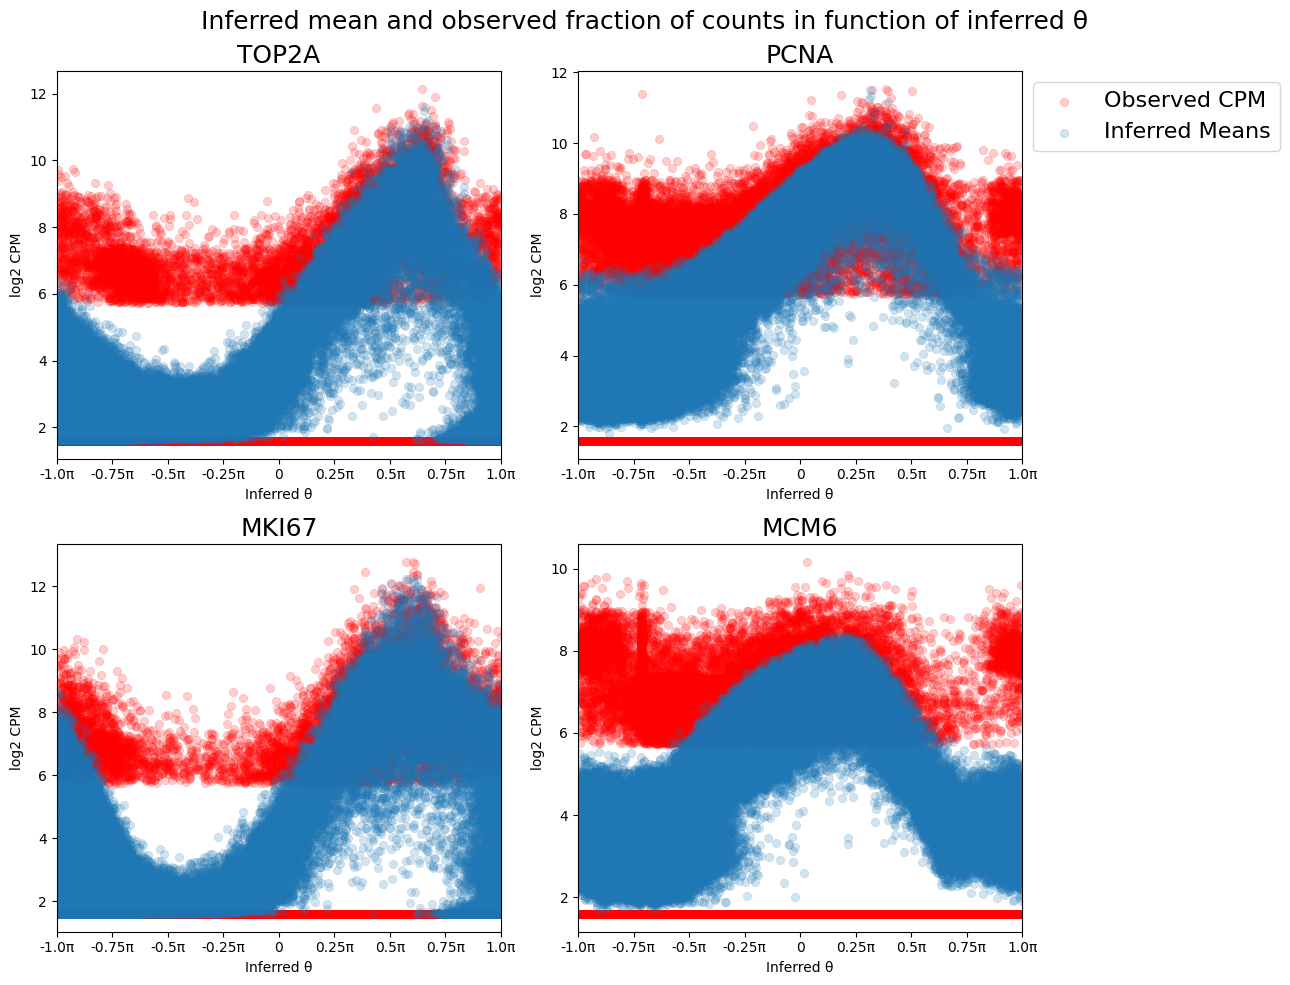

In [ ]:
# plot the two with different y scales
genes = ["Top2a", "Pcna", "Mki67", "Mcm6"]
plotting.plot_gene_profile(
    df_mean, adata, genes, layer_to_use="total", library_size=library_size
)

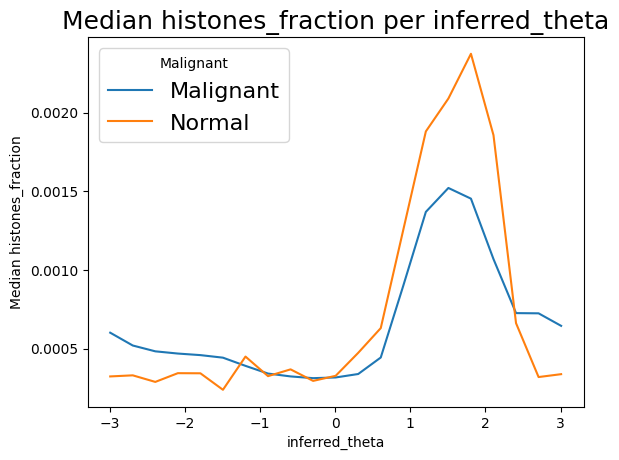

In [ ]:
utils.add_histones_fraction(adata=adata, layer="total")

library_size = adata.layers["total"].sum(axis=1).A1
adata.obs["library_size"] = library_size
adata.obs["inferred_theta"] = df_z["inferred_theta"].to_numpy()
plotting.plot_smoothed_size_evolution(
    adata[cycling_cells],
    "inferred_theta",
    counts_sum_field="histones_fraction",
    hue="Malignant",
)

In [ ]:
adata.obs

GEO_ID Lambo_et_al_ID Patient_Sample Library_ID  \
AAACCCAAGAACGCGT-1  PAVJXG_Rel_scRNA           AML8        Relapse   AML8_REL   
AAACCCAAGAAGGATG-1  PAWWCW_Rel_scRNA          AML11        Relapse  AML11_REL   
AAACCCAAGAATCGCG-1   PAWNYX_Dx_scRNA           AML6      Diagnosis    AML6_DX   
AAACCCAAGACGATAT-1   PAVGJG_Dx_scRNA          AML18      Diagnosis   AML18_DX   
AAACCCAAGACGCCCT-1  PAUVAT_Rel_scRNA          AML26        Relapse  AML26_REL   
...                              ...            ...            ...        ...   
TTTGTTGTCTGATGGT-1   PAWUAE_Dx_scRNA           AML5      Diagnosis    AML5_DX   
TTTGTTGTCTGATTCT-1  PAWNPG_Rem_scRNA          AML13      Remission  AML13_REM   
TTTGTTGTCTGGACCG-1  PAUZRT_Rel_scRNA          AML16        Relapse  AML16_REL   
TTTGTTGTCTGGTTGA-1   PAWRVC_Dx_scRNA           AML9      Diagnosis    AML9_DX   
TTTGTTGTCTTTGATC-1  PAWUAE_Rel_scRNA           AML5        Relapse   AML5_REL   

                    Counts  Features  Mitochondria_percent  \
AAACCCAAGAACGCGT-1   11235      2151              7.556742   
AAACCCAAGAAGGATG-1    4352      1129              6.571691   
AAACCCAAGAATCGCG-1    7211      2064              9.638053   
AAACCCAAGACGATAT-1   14966      3790              5.672858   
AAACCCAAGACGCCCT-1   10567      2983              7.192202   
...                    ...       ...                   ...   
TTTGTTGTCTGATGGT-1    8566      2543              7.681532   
TTTGTTGTCTGATTCT-1    2125       880              6.635294   
TTTGTTGTCTGGACCG-1    9354      2477              7.258927   
TTTGTTGTCTGGTTGA-1    6593      2056              5.156985   
TTTGTTGTCTTTGATC-1    3046      1011              7.419567   

                   Classified_Celltype  Seurat_Cluster  Malignant  ...  \
AAACCCAAGAACGCGT-1          Progenitor               0  Malignant  ...   
AAACCCAAGAAGGATG-1           CD4.Naive               1     Normal  ...   
AAACCCAAGAATCGCG-1                 GMP               1  Malignant  ...   
AAACCCAAGACGATAT-1          Progenitor               8  Malignant  ...   
AAACCCAAGACGCCCT-1          Progenitor               4  Malignant  ...   
...                                ...             ...        ...  ...   
TTTGTTGTCTGATGGT-1           Monocytes              11  Malignant  ...   
TTTGTTGTCTGATTCT-1                 GMP               3     Normal  ...   
TTTGTTGTCTGGACCG-1                 HSC              10  Malignant  ...   
TTTGTTGTCTGGTTGA-1           Monocytes               1  Malignant  ...   
TTTGTTGTCTTTGATC-1              B.Cell              12     Normal  ...   

                   nCount_RNA nFeature_RNA             sample_id  \
AAACCCAAGAACGCGT-1      11235         2151   GSM7494275_AML8_REL   
AAACCCAAGAAGGATG-1       4352         1129  GSM7494296_AML11_REL   
AAACCCAAGAATCGCG-1       7211         2064    GSM7494260_AML6_DX   
AAACCCAAGACGATAT-1      14966         3790   GSM7494324_AML18_DX   
AAACCCAAGACGCCCT-1      10567         2983  GSM7494320_AML26_REL   
...                       ...          ...                   ...   
TTTGTTGTCTGATGGT-1       8566         2543    GSM7494279_AML5_DX   
TTTGTTGTCTGATTCT-1       2125          880  GSM7494331_AML13_REM   
TTTGTTGTCTGGACCG-1       9354         2477  GSM7494258_AML16_REL   
TTTGTTGTCTGGTTGA-1       6593         2056    GSM7494289_AML9_DX   
TTTGTTGTCTTTGATC-1       3046         1011   GSM7494280_AML5_REL   

                                   batch  n_cell_cycle_counts pca_theta  \
AAACCCAAGAACGCGT-1   GSM7494275_AML8_REL             0.000445 -3.049478   
AAACCCAAGAAGGATG-1  GSM7494296_AML11_REL             0.000919 -3.060291   
AAACCCAAGAATCGCG-1    GSM7494260_AML6_DX             0.000555 -2.959128   
AAACCCAAGACGATAT-1   GSM7494324_AML18_DX             0.005212  0.320318   
AAACCCAAGACGCCCT-1  GSM7494320_AML26_REL             0.002271  2.185501   
...                                  ...                  ...       ...   
TTTGTTGTCTGATGGT-1    GSM7494279_AML5_DX             0.001401 -1.521373   
TTTGTT

In [ ]:
# save adata
# adata.write("cycling_selected.h5ad")

<Axes: ylabel='Patient_Sample'>

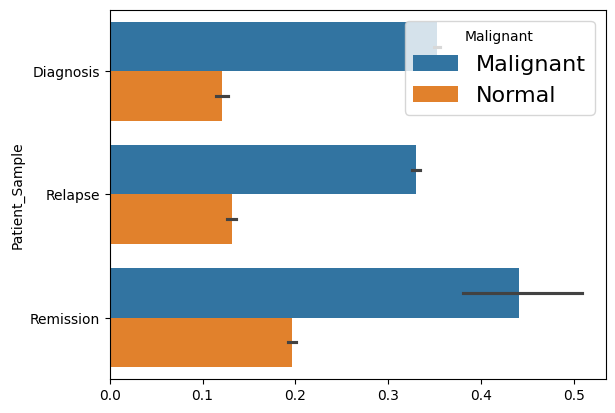

In [ ]:
sns.barplot(
    x=cycling_cells,
    hue=adata.obs["Malignant"],
    y=adata.obs["Patient_Sample"],
)

In [ ]:
adata_ER = adata

In [ ]:
adata.obs["disease_status"] = adata.obs["Patient_Sample"].astype(str)
adata.obs.loc[
    (adata.obs["Malignant"] == "Malignant")
    & (adata.obs["Patient_Sample"] == "Relapse")
    & (adata.obs["Disease_free_days"] < 200),
    "disease_status",
] = "Rapid Relapse (<200 days)"
adata.obs.loc[
    (adata.obs["Malignant"] == "Malignant")
    & (adata.obs["Patient_Sample"] == "Remission"),
    "disease_status",
] = "Rapid Relapse (<200 days)"

In [ ]:
g1_g0_cells = (thetas > -2.5) & (thetas < -1)
g1_g0_cells = g1_g0_cells.detach().numpy()

In [ ]:
proliferating = (cycling_cells) & (~g1_g0_cells)

In [ ]:
adata.obs["Patient_Sample"]

AAACCCAAGAACGCGT-1      Relapse
AAACCCAAGAAGGATG-1      Relapse
AAACCCAAGAATCGCG-1    Diagnosis
AAACCCAAGACGATAT-1    Diagnosis
AAACCCAAGACGCCCT-1      Relapse
                        ...    
TTTGTTGTCTGATGGT-1    Diagnosis
TTTGTTGTCTGATTCT-1    Remission
TTTGTTGTCTGGACCG-1      Relapse
TTTGTTGTCTGGTTGA-1    Diagnosis
TTTGTTGTCTTTGATC-1      Relapse
Name: Patient_Sample, Length: 181783, dtype: category
Categories (3, object): ['Diagnosis', 'Relapse', 'Remission']

In [ ]:
adata.obs.iloc[:, :20]

GEO_ID Lambo_et_al_ID Patient_Sample Library_ID  \
AAACCCAAGAACGCGT-1  PAVJXG_Rel_scRNA           AML8        Relapse   AML8_REL   
AAACCCAAGAAGGATG-1  PAWWCW_Rel_scRNA          AML11        Relapse  AML11_REL   
AAACCCAAGAATCGCG-1   PAWNYX_Dx_scRNA           AML6      Diagnosis    AML6_DX   
AAACCCAAGACGATAT-1   PAVGJG_Dx_scRNA          AML18      Diagnosis   AML18_DX   
AAACCCAAGACGCCCT-1  PAUVAT_Rel_scRNA          AML26        Relapse  AML26_REL   
...                              ...            ...            ...        ...   
TTTGTTGTCTGATGGT-1   PAWUAE_Dx_scRNA           AML5      Diagnosis    AML5_DX   
TTTGTTGTCTGATTCT-1  PAWNPG_Rem_scRNA          AML13      Remission  AML13_REM   
TTTGTTGTCTGGACCG-1  PAUZRT_Rel_scRNA          AML16        Relapse  AML16_REL   
TTTGTTGTCTGGTTGA-1   PAWRVC_Dx_scRNA           AML9      Diagnosis    AML9_DX   
TTTGTTGTCTTTGATC-1  PAWUAE_Rel_scRNA           AML5        Relapse   AML5_REL   

                    Counts  Features  Mitochondria_percent  \
AAACCCAAGAACGCGT-1   11235      2151              7.556742   
AAACCCAAGAAGGATG-1    4352      1129              6.571691   
AAACCCAAGAATCGCG-1    7211      2064              9.638053   
AAACCCAAGACGATAT-1   14966      3790              5.672858   
AAACCCAAGACGCCCT-1   10567      2983              7.192202   
...                    ...       ...                   ...   
TTTGTTGTCTGATGGT-1    8566      2543              7.681532   
TTTGTTGTCTGATTCT-1    2125       880              6.635294   
TTTGTTGTCTGGACCG-1    9354      2477              7.258927   
TTTGTTGTCTGGTTGA-1    6593      2056              5.156985   
TTTGTTGTCTTTGATC-1    3046      1011              7.419567   

                   Classified_Celltype  Seurat_Cluster  Malignant Patient_ID  \
AAACCCAAGAACGCGT-1          Progenitor               0  Malignant     PAVJXG   
AAACCCAAGAAGGATG-1           CD4.Naive               1     Normal     PAWWCW   
AAACCCAAGAATCGCG-1                 GMP               1  Malignant     PAWNYX   
AAACCCAAGACGATAT-1          Progenitor               8  Malignant     PAVGJG   
AAACCCAAGACGCCCT-1          Progenitor               4  Malignant     PAUVAT   
...                                ...             ...        ...        ...   
TTTGTTGTCTGATGGT-1           Monocytes              11  Malignant     PAWUAE   
TTTGTTGTCTGATTCT-1                 GMP               3     Normal     PAWNPG   
TTTGTTGTCTGGACCG-1                 HSC              10  Malignant     PAUZRT   
TTTGTTGTCTGGTTGA-1           Monocytes               1  Malignant     PAWRVC   
TTTGTTGTCTTTGATC-1              B.Cell              12     Normal     PAWUAE   

                   Biopsy_Origin  Age_Months  Disease_free_days  \
AAACCCAAGAACGCGT-1        Marrow          87                517   
AAACCCAAGAAGGATG-1         Blood           0                472   
AAACCCAAGAATCGCG-1         Blood          90                335   
AAACCCAAGACGATAT-1         Blood          13                298   
AAACCCAAGACGCCCT-1        Marrow         102                291   
...                          ...         ...                ...   
TTTGTTGTCTGATGGT-1        Marrow          23                214   
TTTGTTGTCTGATTCT-1        Marrow          47                578   
TTTGTTGTCTGGACCG-1        Marrow         155                548   
TTTGTTGTCTGGTTGA-1         Blood         117                503   
TTTGTTGTCTTTGATC-1        Marrow          23                214   

                    Clinical_Blast_Percent Expected_Driving_Aberration  \
AAACCCAAGAACGCGT-1                    68.0                 KMT2A-MLLT3   
AAACCCAAGAAGGATG-1                    76.0                KMT2A-MLLT10   
AAACCCAAGAATCGCG-1                    80.0                 KMT2A-MLLT3   
AAACCCAAGACGATAT-1                    47.0                  CBFB-MYH11   
AAACCCAAGACGCCCT-1                    71.0               MLLT10-NAP1L1   
...                                    ...                         ...   
TTTGTTGTCTGATGGT-1          

In [ ]:
i = (adata.obs["Malignant"] == "Malignant").values & (
    adata.obs["Patient_Sample"] == "Relapse"
)
adata.obs["Classified_Celltype"][i].value_counts()

Classified_Celltype
Progenitor           19500
HSC                  14772
GMP                   4730
Monocytes             2904
CLP                   2057
Early.Erythrocyte     1298
cDC                    391
Pre.B.Cell             389
pDC                    273
CD16.Monocytes         212
Early.Basophil         168
Unknown                 85
Late.Erythrocyte        49
CD4.Naive               31
CD4.Memory              13
B.Cell                   8
CD8.Memory               3
CD8.Naive                0
NK                       0
Plasma                   0
CD8.Effector             0
Name: count, dtype: int64

In [ ]:
adata.obs["dividing"] = adata.obs["inferred_theta"] > 0

In [ ]:
adata[adata.obs["Malignant"] == "Malignant"].obs.groupby(
    ["Treatment_Outcome", "Patient_Sample"]
)["dividing"].mean()

/tmp/ipykernel_623494/1083596921.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata[adata.obs["Malignant"] == "Malignant"].obs.groupby(


Treatment_Outcome  Patient_Sample
Censored           Diagnosis         0.102750
                   Relapse                NaN
                   Remission              NaN
Relapsed           Diagnosis         0.111771
                   Relapse           0.101316
                   Remission         0.252137
Name: dividing, dtype: float64

In [ ]:
res = {}
for name, group in adata[adata.obs["dividing"]].obs.groupby(
    ["Malignant", "Patient_Sample"]
):
    print(name)
    res[name] = np.array(
        np.log1p(
            adata[group.index].layers["total"]
            / adata[group.index].layers["total"].sum(axis=1)
            * 1e4
        ).mean(axis=0)
    ).flatten()
res = pd.DataFrame(res, index=adata.var_names)

/tmp/ipykernel_623494/888290632.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in adata[adata.obs["dividing"]].obs.groupby(


('Malignant', 'Diagnosis')


('Malignant', 'Relapse')
('Malignant', 'Remission')
('Normal', 'Diagnosis')
('Normal', 'Relapse')
('Normal', 'Remission')


In [ ]:
res["Malignant"].sub(res["Normal"].mean(axis=1), axis=0).sort_values(
    by="Diagnosis", ascending=False
).head(20)

Diagnosis   Relapse  Remission
LYZ       2.136108  0.629900   0.239965
LGALS1    1.992224  1.422743   0.357532
TUBA1B    1.925634  2.235433   1.991846
STMN1     1.832515  2.172976   1.679022
GAPDH     1.809219  1.953979   1.618724
H2AFZ     1.711577  1.796334   1.406955
GSTP1     1.709993  1.731052   1.662225
VIM       1.664038  0.956632   0.754673
ENO1      1.657651  1.669497   1.200978
TUBB      1.652269  1.811202   1.484761
SRGN      1.610663  0.911017   1.114171
CLEC11A   1.577999  1.320213   0.642828
PCLAF     1.542401  1.659313   1.277214
TXN       1.497706  1.424951   1.262449
CST3      1.476033  0.987016   0.968671
ANXA1     1.465530  0.827054   0.746610
HSP90B1   1.462010  0.985146   0.939479
HLA-DRA   1.443334  1.200986   0.908818
DUT       1.423606  1.480901   1.277272
H2AFY     1.410304  1.634165   1.326731

In [ ]:
gene_sets.SMALL_CELL_CYCLE_GENE_SET

array(['Anln', 'Anp32e', 'Atad2', 'Aurka', 'Aurkb', 'Birc5', 'Blm',
       'Brip1', 'Bub1', 'Casp8ap2', 'Cbx5', 'Ccnb2', 'Ccne2', 'Cdc20',
       'Cdc25c', 'Cdc45', 'Cdc6', 'Cdca2', 'Cdca3', 'Cdca7', 'Cdca8',
       'Cdk1', 'Cenpa', 'Cenpe', 'Cenpf', 'Cenpu', 'Chaf1b', 'Ckap2',
       'Ckap2l', 'Ckap5', 'Cks1b', 'Cks2', 'Clspn', 'Ctcf', 'Dlgap5',
       'Dscc1', 'Dtl', 'E2f8', 'Ect2', 'Esco2', 'Exo1', 'Fen1', 'G2e3',
       'Gas2l3', 'Gins2', 'Gmnn', 'Gtse1', 'Hells', 'Hjurp', 'Hmgb2',
       'Hmmr', 'Jpt1', 'Kif11', 'Kif20b', 'Kif23', 'Kif2c', 'Lbr', 'Mcm2',
       'Mcm4', 'Mcm5', 'Mcm6', 'Mki67', 'Msh2', 'Nasp', 'Ncapd2', 'Ndc80',
       'Nek2', 'Nuf2', 'Nusap1', 'Pcna', 'Pimreg', 'Pola1', 'Pold3',
       'Prim1', 'Psrc1', 'Rad51', 'Rad51ap1', 'Rangap1', 'Rfc2', 'Rpa2',
       'Rrm1', 'Rrm2', 'Slbp', 'Smc4', 'Tacc3', 'Tipin', 'Tmpo', 'Top2a',
       'Tpx2', 'Ttk', 'Tubb4b', 'Tyms', 'Ube2c', 'Ubr7', 'Uhrf1', 'Ung',
       'Usp1', 'Wdr76'], dtype='<U8')

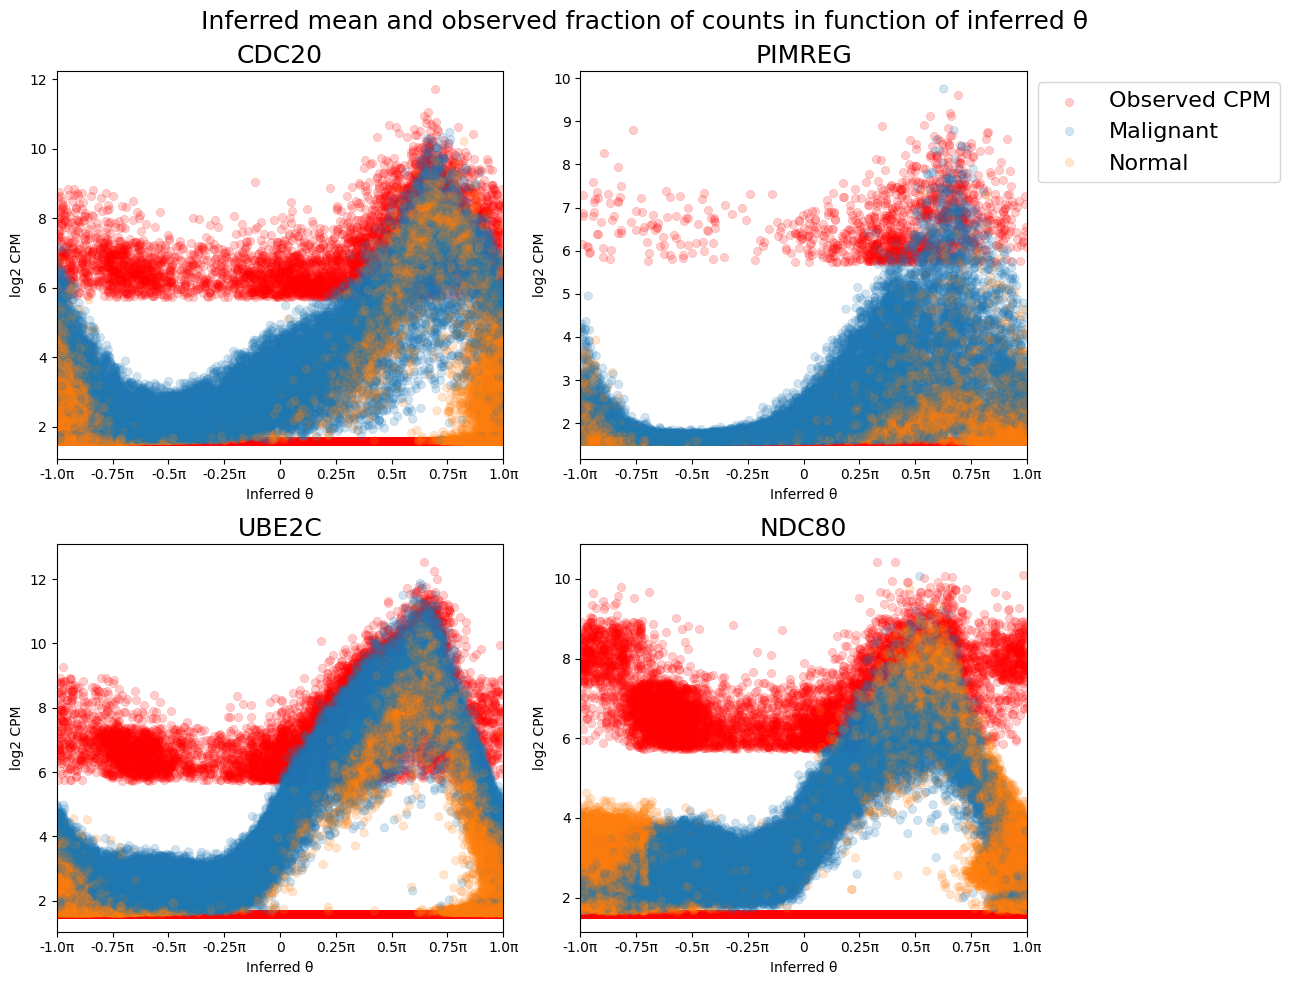

In [ ]:
plotting.plot_gene_profile(
    df_mean,
    adata,
    genes=["CDC20", "PIMREG", "UBE2C", "NDC80"],
    layer_to_use="total",
    library_size=library_size,
    hue=adata.obs["Malignant"].values,
)

In [ ]:
adata.obs["library_size"] = library_size
# adata.obs["inferred_theta"] = df_mean["inferred_theta"].to_numpy()

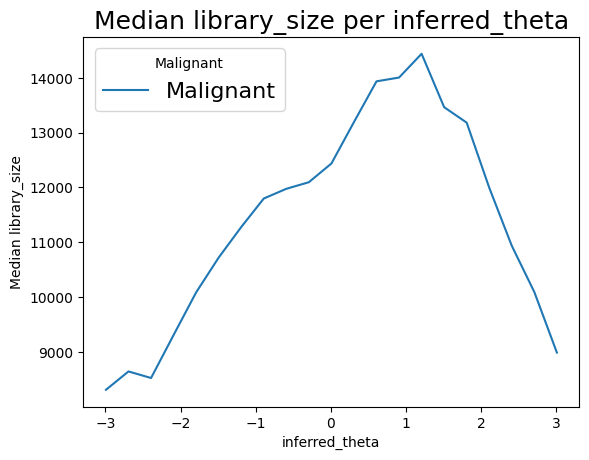

In [ ]:
plotting.plot_smoothed_size_evolution(
    adata[adata.obs["Malignant"] == "Malignant"], "inferred_theta", hue="Malignant"
)

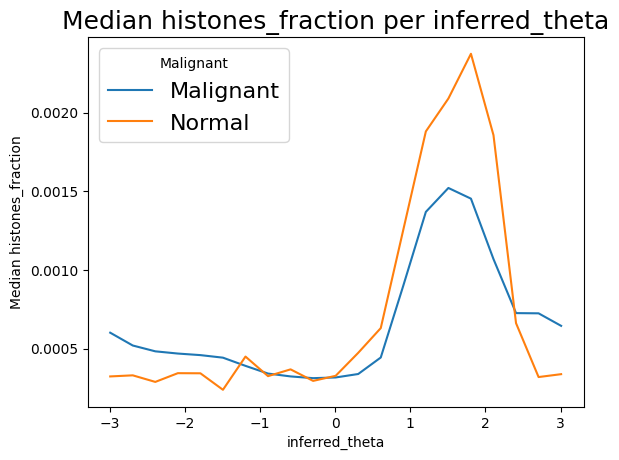

In [ ]:
plotting.plot_smoothed_size_evolution(
    adata[cycling_cells],
    "inferred_theta",
    counts_sum_field="histones_fraction",
    hue="Malignant",
)

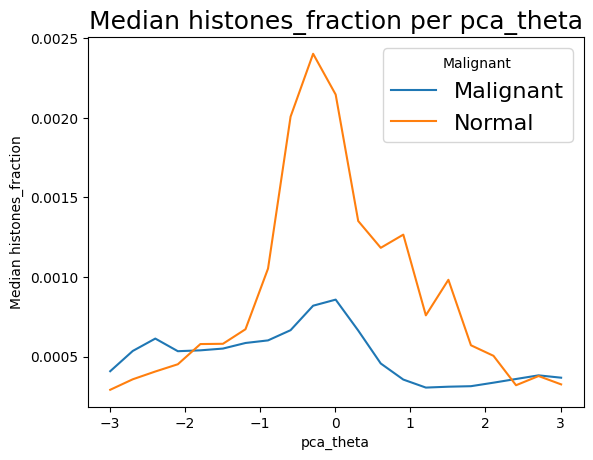

In [ ]:
plotting.plot_smoothed_size_evolution(
    adata[cycling_cells],
    "pca_theta",
    counts_sum_field="histones_fraction",
    hue="Malignant",
)

/home/maxine/miniconda3/envs/VAE_Fourrier_Env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


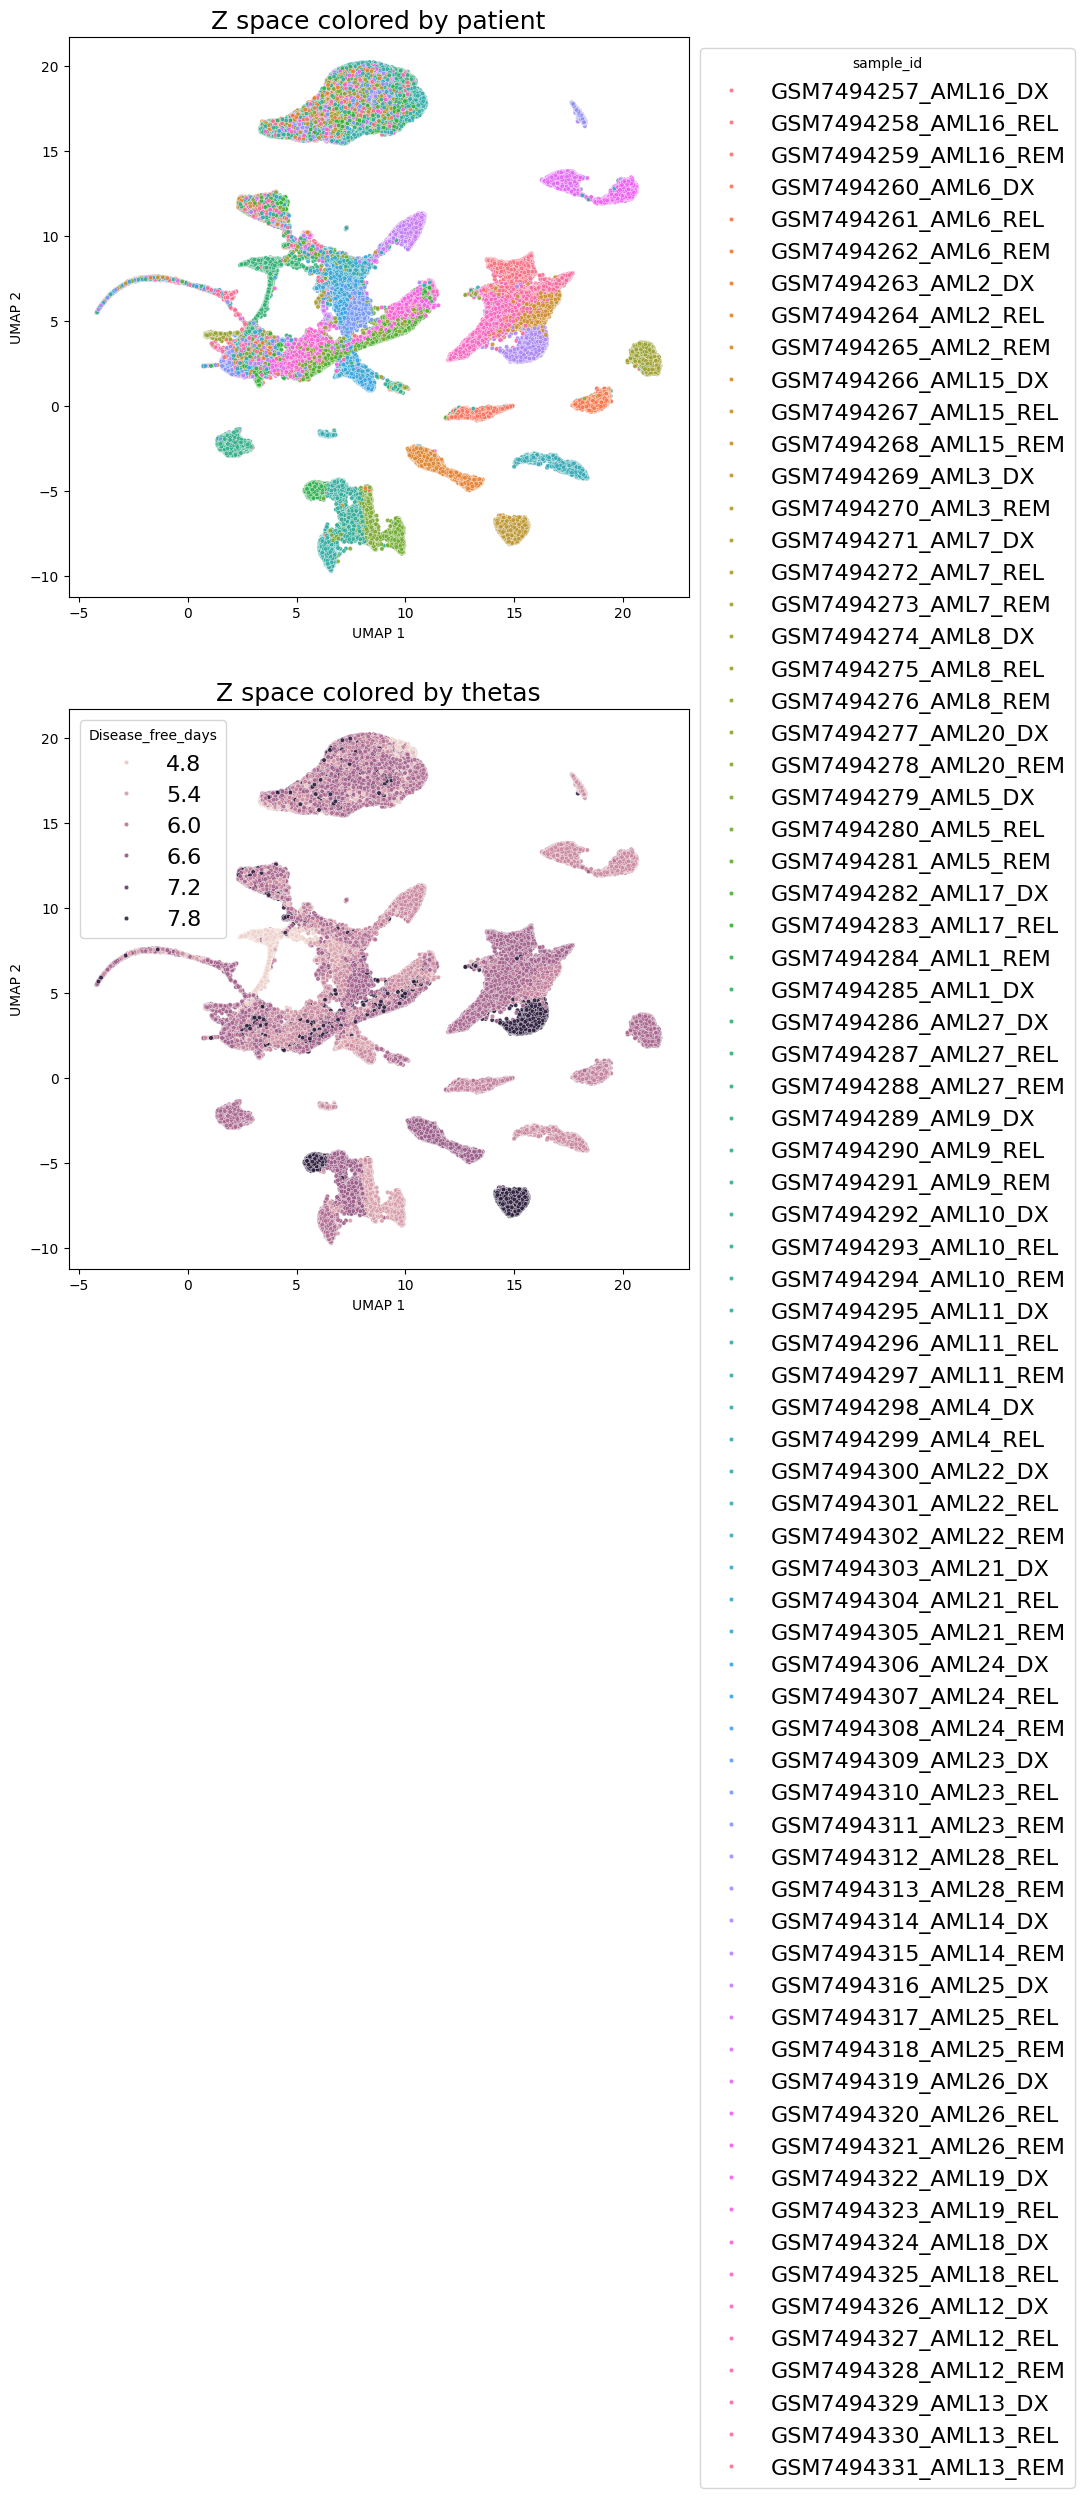

In [ ]:
plotting.plot_z_space(
    space_outputs["z"],
    adata.obs["sample_id"].astype("category"),
    np.log(adata.obs["Disease_free_days"]),
    cell_identity_label="patient",
)

/home/maxine/miniconda3/envs/VAE_Fourrier_Env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


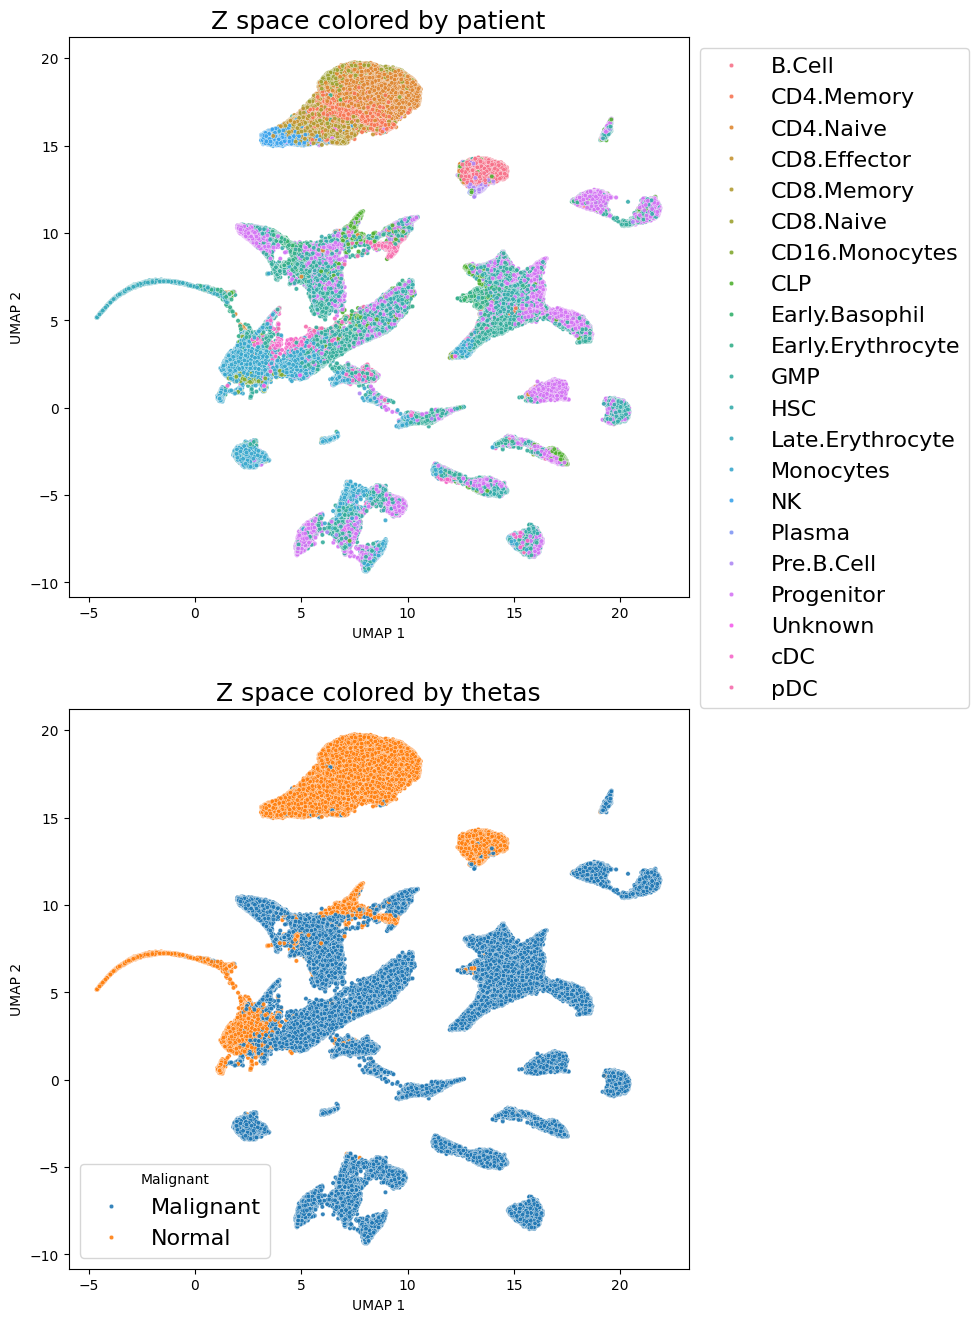

In [ ]:
plotting.plot_z_space(
    space_outputs["z"],
    adata.obs["Classified_Celltype"].values,
    adata.obs["Malignant"],
    cell_identity_label="patient",
)

/home/maxine/Documents/paychere/cell_cycle_VAE_Fourrier_model/src/CoPhaser/plotting.py:197: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


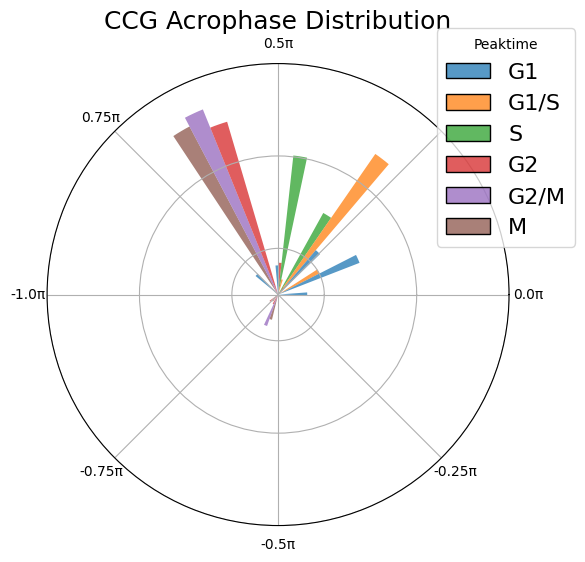

In [ ]:
plotting.plot_cell_cycle(df_rhythmic)

/home/maxine/miniconda3/envs/VAE_Fourrier_Env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: >

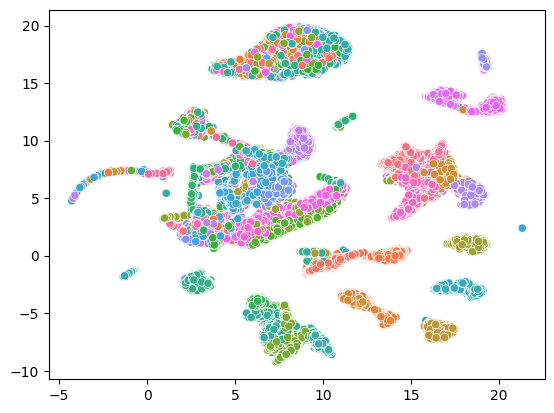

In [ ]:
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(space_outputs["z"].detach().numpy())
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=adata.obs["sample_id"].astype("category"),
    legend=False,
)

In [ ]:
# to_save = {
#     "z_space_embedding": embedding,
#     "inferred_theta": df_mean["inferred_theta"].to_numpy(),
#     "cycling_cells": cycling_cells,
#     "latent_z": space_outputs["z"].detach().numpy(),
#     "adata": adata,
#     "df_f": df_rhythmic,
#     "df_z": df_z,
#     "df_mean": df_mean,
#     "logits": space_outputs["cycling_logits"].detach().numpy(),
# }

In [ ]:
# import pickle

# with open("data/pediatric_AML.pkl", "wb") as f:
#     pickle.dump(to_save, f)